#The assignment is to investigate and analyze the accompanying data set, producing a model that can be used to predict the “target”.#

Since Tempus deals with the data to see if it is clinically informative, I have assumed the data to be medical data and target to be synonymous to disease. Disease is there if target is 1, else 0

In [443]:
#Importing all the required packages

import json
import pandas as pd
import missingno as mi
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from numpy import arange
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 

In [374]:
#Reading the json file and then converting it into a dataframe

with open('patient_profiles.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)

Parser to parse data for each patient from the json file into a dataframe

In [375]:
rows_list = []
for x in df['patient_profiles']:
  for p in x:
    dict1 = {}
    #print(p)
    for k,v in p.items():
      if(type(v) == dict):
        for k1, v1 in v.items():
          dict1[k + '.'+ k1] = v1
      else:
        dict1[k]= v
    rows_list.append(dict1)
patients_df = pd.DataFrame(rows_list) 
patients_df.head(5)
patients_df.shape

(2351, 13)

In [376]:
patients_df.head(5)

,patient_id,demographics.gender,demographics.age,status.disease_sub_type,status.comorbidity_index,status.cohort_qualifier,status.smoking_status,status.months_since_diagnosis,demographics.race,status.days_since_diagnosis,status.alcohol_usage,status.exercise_frequency,status.bmi_level
0,102bb8fae,Female,68.0,A,0.0,True,never,1.0,NaN,NaN,NaN,NaN,NaN
1,10e32947f,Female,66.0,A,NaN,True,former,0.0,White,NaN,NaN,NaN,NaN
2,11156e14a,Male,61.0,A,1.0,True,never,16.0,White,NaN,NaN,NaN,NaN
3,113d8066d,Male,62.0,B,NaN,True,current,0.0,NaN,NaN,NaN,NaN,NaN
4,113ec3f1,Male,59.0,A,NaN,True,former,9.0,NaN,NaN,NaN,NaN,NaN


The above dataframe contains data for all the patients across all seven cohorts or medical institutions. I have created the column names with 'keyname'.'nested_keyname'. We have total 2351 rows and 13 columns



In [377]:
#Reading the biomarkers and targets file

biomarkers = pd.read_csv("biomarkers.csv")
targets = pd.read_csv("targets.csv")

In [378]:
biomarkers.head(5)
biomarkers.shape

(1960, 15158)

In [379]:
targets.head(5)
len(biomarkers['biomarker_id'].unique())
targets.shape

(1734, 3)

Now, we'll merge the data from biomarkers and targets file on the biomarker_id to get one file to get target labels and all biomarkers columns in one dataframe

In [380]:
merged_data = biomarkers.merge(targets, on = 'biomarker_id', how = 'inner')
merged_data.shape

(1734, 15160)

Now, I have used the above merged file and merged it with patients data file on patients id to get one dataframe with all biomakers columns, patient's data columns and of course the target label

In [381]:
final_data = merged_data.merge(patients_df, on = 'patient_id', how = 'inner')
final_data.head(5)

,biomarker_id,BM00000,BM00001,BM00002,BM00003,BM00004,BM00005,BM00006,BM00007,BM00008,...,status.disease_sub_type,status.comorbidity_index,status.cohort_qualifier,status.smoking_status,status.months_since_diagnosis,demographics.race,status.days_since_diagnosis,status.alcohol_usage,status.exercise_frequency,status.bmi_level
0,100505de2,1,1,1,0,0,0,1,0,0,...,C,NaN,True,NaN,NaN,NaN,148.0,NaN,NaN,NaN
1,10075c5c2,1,1,1,0,0,0,1,0,1,...,A,NaN,True,never,79.0,NaN,NaN,NaN,NaN,NaN
2,10105cb22,1,1,1,0,0,0,1,0,1,...,A,1.0,True,unknown,0.0,White,NaN,NaN,NaN,NaN
3,101219d6e,1,0,1,0,0,0,0,0,1,...,A,NaN,True,current,0.0,Black or African American,NaN,NaN,NaN,NaN
4,10135ad45,1,0,1,0,1,0,1,0,1,...,C,NaN,True,never,0.0,Black or African American,NaN,NaN,NaN,NaN


#EDA#

Since I don't have any contextual knowledge about biomarkers, I won't do any EDA specifically in the biomarkers column

In [382]:
final_data.describe()

,BM00000,BM00001,BM00002,BM00003,BM00004,BM00005,BM00006,BM00007,BM00008,BM00009,...,BM15153,BM15154,BM15155,BM15156,target_label,demographics.age,status.comorbidity_index,status.months_since_diagnosis,status.days_since_diagnosis,status.exercise_frequency
count,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,...,1734.0,1038.000000,1734.000000,1734.000000,1734.000000,1611.000000,353.000000,1611.000000,123.000000,330.000000
mean,0.783160,0.883506,0.725490,0.189158,0.434256,0.064014,0.538062,0.096309,0.931373,0.592272,...,1.0,0.982659,0.914648,0.969435,0.219723,59.790813,0.716714,6.800124,253.528455,0.275758
std,0.412211,0.320909,0.446396,0.391747,0.495802,0.244848,0.498693,0.295100,0.252892,0.491554,...,0.0,0.130602,0.279485,0.172186,0.414179,9.516331,0.786374,10.842854,388.136940,0.561982
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.0,1.000000,1.000000,1.000000,0.000000,54.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,...,1.0,1.000000,1.000000,1.000000,0.000000,61.000000,1.000000,2.000000,108.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,...,1.0,1.000000,1.000000,1.000000,0.000000,67.000000,1.000000,10.000000,383.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.000000,1.000000,1.000000,1.000000,83.000000,2.000000,93.000000,3084.000000,2.000000


Now, I will look for all the columns with null values and create a datagrame of all the columns which have null values and the number of null values for each of them respectively

In [383]:
check_null_columns = final_data.isnull().sum()
check_null_columns = check_null_columns.reset_index()

check_null_columns = check_null_columns[check_null_columns[0] > 0 ]
check_null_columns.head(5)

,index,0
1070,BM01069,696
1255,BM01254,696
1672,BM01671,696
2182,BM02181,696
2499,BM02498,696


In [399]:
drop_columns_list = list(check_null_columns[check_null_columns[0] >600]['index'])
drop_columns_list[0:5]

['BM01069', 'BM01254', 'BM01671', 'BM02181', 'BM02498']

#Feature engineering#

Above is the list of all columns which we'll drop. I'm dropping all the biomarkers because I don't have any information or contextual knowledge about them. So, I can't impute any data. I'm dropping all the patient's data (all the above mentioned status) because out of 1734, more than 60% of them are null values. Thus, following the cardinality rule for dropping these. Also, dropping patient_id and biomarker_id as it doesn't add any information about target

In [385]:
final_data_filtered = final_data.drop(drop_columns_list, axis=1, inplace=False)
final_data_filtered.drop(['biomarker_id', 'patient_id'], axis=1, inplace=True)

We see above that column = status.cohort_qualifier has only one value, True so if we convert it into dummy, it won't help and contribute any knowledge to the model. So, it is safe to drop this column

In [386]:
final_data_filtered.drop(['status.cohort_qualifier'], axis=1, inplace=True)

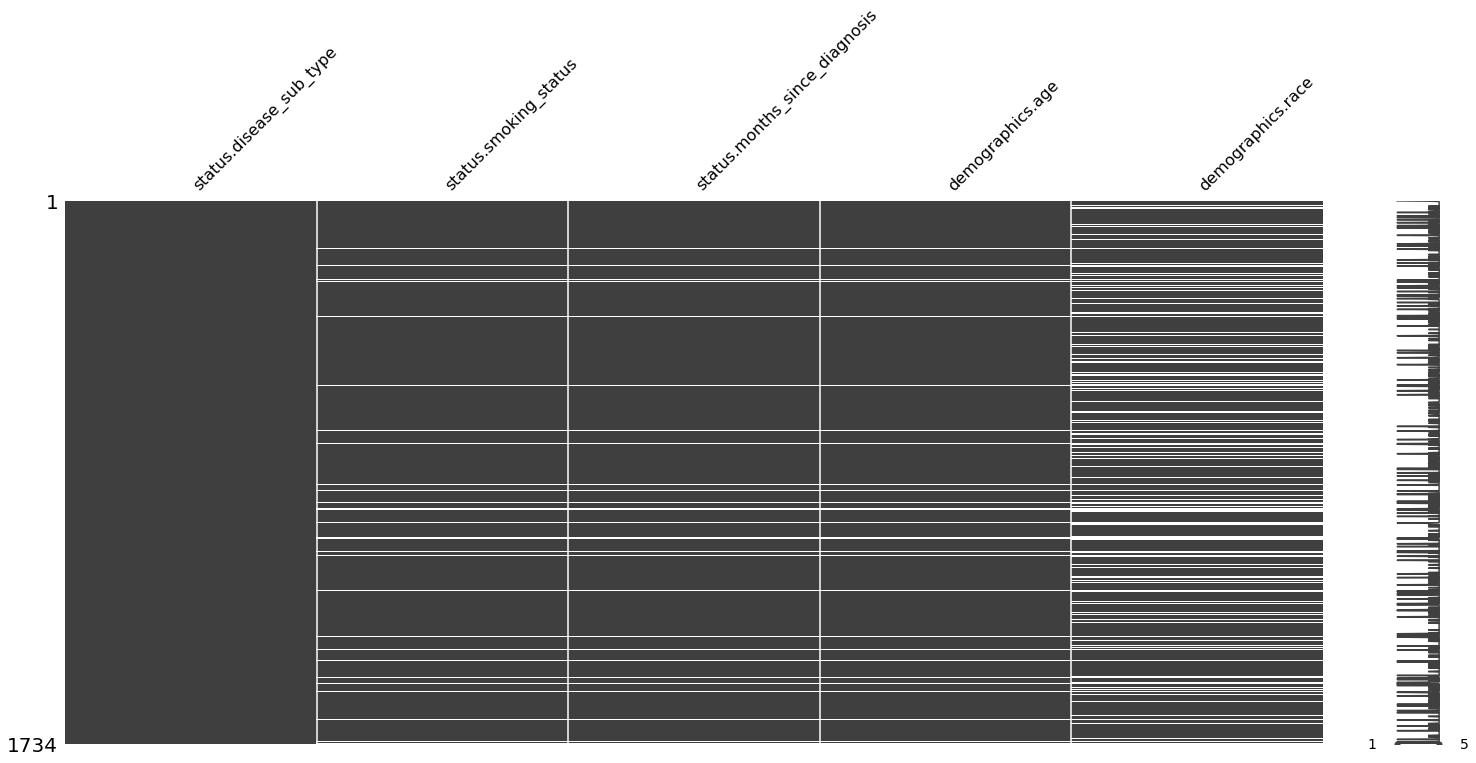

In [391]:
#Plotting the columns with null values to see if any pattern exist among the columns

final_data_filtered_status = [col for col in final_data_filtered if col.startswith('status')]
final_data_filtered_status.append('demographics.age', 'demographics.race')

mi.matrix(final_data_filtered[final_data_filtered_status])

Above is the graph for the four columns where we have null values in the data. We can see that all the patients which forgot to enter the information for one columns also don't enter it for the other columns. So, we can improve the data quality process by gathering the data using the patient ids. To deal with the above four columns with missing values, I'll first create a new column for each categorical column to represent if the values exist or not (missing =1, not missing =0). Then I'll create dummy variables for the column with categorical variables and drop the Nan column as base. So, I'm taking into the effect if the column has missing value or not and the effect of the classes of that column. For numerical columns, I'll use the column disease sub type and use the mean value for each section to fill the null values. I'm using this column on the assumption that people in the same disease subtype group will only have similar people in terms of age and when were they diagnosed. This is not the perfect way but given the information that I have, this is the assumption I'm taking. This can be further improved using more domain knowledge to impute the null values

###Imputing the null values in numerical columns with null values###

In [392]:
#Imputing data into quantitative variables: demographics.age and status.months_since_diagnosis_missing usng the mean of the disease subtype group as described in the above text
group_mean = dict(final_data_filtered.groupby(['status.disease_sub_type'])['demographics.age'].mean())
final_data_filtered["demographics.age"] = list(group_mean[final_data_filtered.loc[i, 'status.disease_sub_type']] if pd.isna(final_data_filtered.loc[i, "demographics.age"]) else final_data_filtered.loc[i, "demographics.age"] for i in range(0, len(final_data_filtered.index)))

group_mean_months = dict(final_data_filtered.groupby(['status.disease_sub_type'])['status.months_since_diagnosis'].mean())
final_data_filtered["status.months_since_diagnosis"] = list(group_mean[final_data_filtered.loc[i, 'status.disease_sub_type']] if pd.isna(final_data_filtered.loc[i, "status.months_since_diagnosis"]) else final_data_filtered.loc[i, "demographics.age"] for i in range(0, len(final_data_filtered.index)))



Imputing the null values in categorical columns with null values

In [393]:
#Creating new columns for categorical variables. 1 if the data is missing and 0 if present. This will give the effect of the data missing or not

final_data_filtered['status.smoking_data_missing'] = [0 if isinstance(value, str) else 1 for value in final_data_filtered['status.smoking_status']]
final_data_filtered['demographics.race_missing'] = [0 if isinstance(value, str) else 1 for value in final_data_filtered['demographics.race']]

#Converting all the values to lower case because never and NEVER mean the same thing

final_data_filtered['demographics.gender'] = final_data_filtered['demographics.gender'].str.lower()
final_data_filtered['status.smoking_status'] = final_data_filtered['status.smoking_status'].str.lower()
final_data_filtered['demographics.race'] = final_data_filtered['demographics.race'].str.lower()


###Creating dummy variables for all the present categorical variables###

In [ ]:
final_data_filtered =pd.get_dummies(final_data_filtered, columns= ['demographics.gender'], drop_first=True)
final_data_filtered =pd.get_dummies(final_data_filtered, columns= ['status.disease_sub_type'], drop_first=True)
final_data_filtered =pd.get_dummies(final_data_filtered, columns= ['status.smoking_status'])
final_data_filtered =pd.get_dummies(final_data_filtered, columns= ['demographics.race'])

final_data_filtered.head(5)

In the above code, we did not remove the null values but instead used it as the base in dummies and removed it. So, we have now the effect of a value of a column being null or not, and the value present if it's not null

Since, now we have our dataset ready and there are no null values left, the dataset is cleaned and transformed for modelling. I'll do the Lasso first since there are more than 15k columns and only 1734 rows. I'll do this to first do the feature selection and then use the selected features to perform logistic regression

In [414]:
#Splitting the data into X and y with X being the dataset of all the independent variables and y being the dependent variable

X, y= final_data_filtered.loc[:, final_data_filtered.columns != 'target_label'], final_data_filtered.loc[:, ['target_label']]

In [415]:
#Scaling the data to get everything into same scale

Min_Max = MinMaxScaler()
X = Min_Max.fit_transform(X)
y= Min_Max.fit_transform(y)

# Split the data into 20% test and 80% training
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape

((1387, 15130), (347, 15130))

In [419]:
#Selecting features using Lasso regularisation using SelectFromModel function from scikit learn

sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel_.fit(X_train, np.ravel(Y_train,order='C'))
sel_.get_support()
X_train = pd.DataFrame(X_train)

In [420]:
#Here we are selecting the selected number of features from Lasso

selected_feat = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
np.sum(sel_.estimator_.coef_ == 0)))

total features: 15130
selected features: 692
features with coefficients shrank to zero: 14438


In the above output, we can see that 14438 feature's coefficients shrunk to zero and only 692 remained in the model. So, we'll only use these in our model now

In [431]:
removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
len(removed_feats) #Removed 14438 features from the data

#Creating a new X dataframe to only select the above selected variables
X_train_selected = sel_.transform(X_train)
X_test_selected = sel_.transform(X_test)
X_train_selected.shape, X_test_selected.shape, Y_train.shape, Y_test.shape

((1387, 692), (347, 692), (1387, 1), (347, 1))

In [433]:
logreg = LogisticRegression()
logreg.fit(X_train_selected, Y_train)

Y_pred = logreg.predict(X_test_selected)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_selected, Y_test)))

Accuracy of logistic regression classifier on test set: 0.78


###Confusion matrix###

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


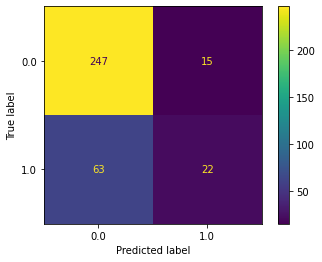

In [445]:
#confusion_matrix = confusion_matrix(Y_test, Y_pred)
#print(confusion_matrix)
plot_confusion_matrix(logreg, X_test_selected, Y_test)  
plt.show()

Assumption: target label= 1 disease is there, 0 means no disease
In the above matrix, we can see that true positives = 247, true negatives = 22 means that our model was able to detect if the patient had the disease when they had the disease and not predict the disease when the patient didn't have it. So, correct predictions. False negative = 63, meaning that the patient didn't have it but it predicted it. **False positive**=15 The model thought the patient had the disease, but they actually didn’t have it. False positive is the most important here because this is where our model couldn't predict the disease when the patient actually had the disease. As per our model, there were 15 patients where it could not detect it.

###ROC-AUC Curve###

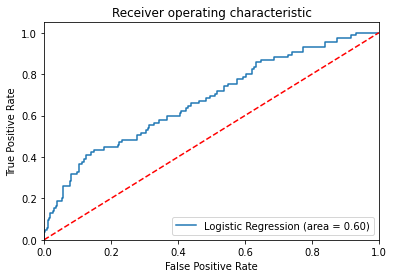

In [453]:
logit_roc_auc = roc_auc_score(Y_test, logreg.predict(X_test_selected))
fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test_selected)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The blue ROC curve is showing the trade-off between our testing data’s true positive rate and false positive rate. The dotted red line cutting through the center of the graph is to provide a sense of what the worst possible model would look like as an ROC curve. 
AUC is the area lies under the ROC curve. The closer this is to 1, the better our classification model is. The AUC of the red dotted line is 0.5. The AUC of a perfect model would be 1. Our line with an AUC of 0.60 which seems to be doing fairly well